## Import libraries

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

## Signal Pre-processing

The preprocessing of data is based on the descriptions in [this paper](https://www.mdpi.com/1424-8220/19/19/4342).

### Windowing the Time Series

In order for the training dataset to cover different levels of vibration, three weight distribution
configurations were done in the cooler blades. For each of these configurations, 17 rotation speeds were set up, ranging from 20% to 100% of the
cooler maximum speed at 5% intervals. Once 1 min of data was collected for each motor speed of the cooler,
represented by 3000 observations. Thus, in total, 153,000 vibration records were collected from the simulation model.
A set of 50 observations of the dataset were defined as the measuring
window, which represent 1 s of signal.

In [2]:
# Load the data from CSV
acceleration_data = np.genfromtxt(
    "./data/download.csv", delimiter=",", skip_header=1
)
print("Number of observations:", len(acceleration_data))

# Separate data into measurement windows of size 50
window_size = 50
num_windows = len(acceleration_data) // window_size
measurement_windows = np.empty((0, 50, 5), dtype="double")
for i in range(num_windows):
    start_idx = i * window_size
    end_idx = start_idx + window_size
    window = acceleration_data[start_idx:end_idx, :]
    measurement_windows = np.append(measurement_windows, [window], axis=0)

Number of observations: 153000


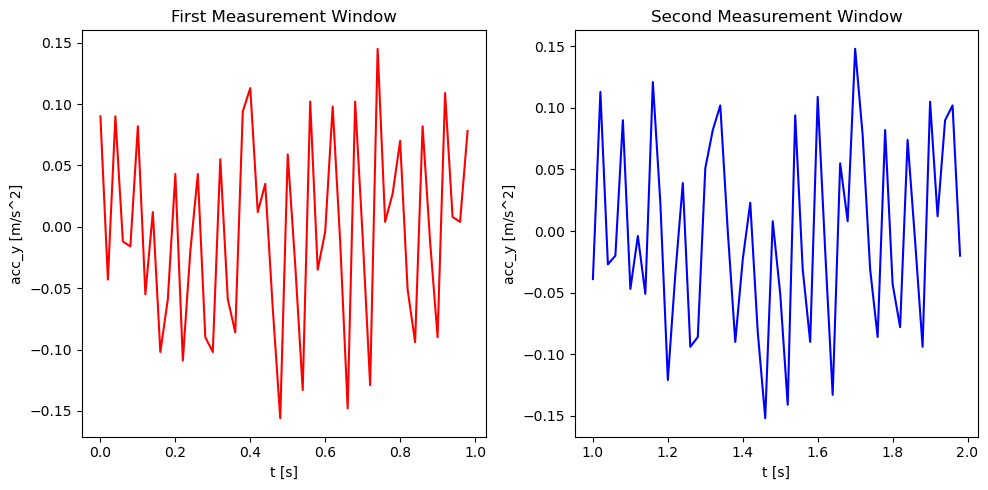

In [3]:
# plot the first two windows of the acceleration in y direction
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(np.arange(0, 1, 0.02), measurement_windows[0, :, 3], color="red")
ax1.set_title("First Measurement Window")
ax1.set_xlabel("t [s]")
ax1.set_ylabel("acc_y [m/s^2]")

ax2.plot(np.arange(1, 2, 0.02), measurement_windows[1, :, 3], color="blue")
ax2.set_title("Second Measurement Window")
ax2.set_xlabel("t [s]")
ax2.set_ylabel("acc_y [m/s^2]")

fig.tight_layout()  # Adjust the spacing between subplots
plt.show()

### Calculating the Amplitude and Frequency Values

The Fourier series and Fourier transform were used to describe the signals in the frequency domain, mapping the various frequencies and amplitudes of the signal. From this transformation it was possible to define a single amplitude and frequency value per axis for each measurement window.
For this purpose, the calculation of the Fourier transform using the Fast Fourier Transform function was implemented in R, with the aid of the ’spectral’ library, generating all pairs of amplitude and frequency of a measurement window.

To generate a unique value, for each window, the Root Mean Square (RMS)
value of the signal, or effective value, for the amplitude and frequency sets, was calculated by the
following function:

In [4]:
def calculate_RMS(signal):
    squared_signal = np.square(signal)
    squared_signal_mean = np.mean(squared_signal)
    rms = np.sqrt(squared_signal_mean)
    return rms

In [5]:
def calculate_and_plot_fft(signal, plot=False):
    fft_result = np.fft.fft(signal)
    sampling_rate = 50  # 20ms for 1sec
    n = len(signal)
    freqs = np.fft.fftfreq(n, d=1 / sampling_rate)
    # the original R-function scales the frquencies with 1/sampling_rate
    freqs = 1 / sampling_rate * freqs
    magnitudes = np.abs(fft_result)
    # the original R-function normalizes to sample count and factor two needed for some scaling reasons
    magnitudes = 2 / n * magnitudes

    freqs_rms = calculate_RMS(freqs)
    magnitudes_rms = calculate_RMS(magnitudes)

    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

        ax1.plot(np.arange(0, 1, 0.02), signal, color="black")
        ax1.set_title("Original acceleration signal")
        ax1.set_xlabel("t [s]")
        ax1.set_ylabel("acc_y [m/s^2]")

        # plot all sine signals with FFT amplitudes and frequencies
        t = np.linspace(0, 1, num=400)
        for i in range(n):
            sine = magnitudes[i] * np.sin(
                2.0 * math.pi * freqs[i] * t * sampling_rate
            )
            ax2.plot(t, sine)
        ax2.set_title("All sine waves resulting from the FFT")
        ax2.set_xlabel("t [s]")
        ax2.set_ylabel("Amplitude [m/s^2]")

        rms_sine = magnitudes_rms * np.sin(
            2.0 * math.pi * freqs_rms * t * sampling_rate
        )
        ax3.plot(t, rms_sine, color="black")
        ax3.set_title("Sine wave corresponding to the RMS of the FFT")
        ax3.set_xlabel("t [s]")
        ax3.set_ylabel("Amplitude [m/s^2]")

        fig.tight_layout()  # Adjust the spacing between subplots
        plt.show()
    return magnitudes_rms, freqs_rms

A new dataset containing 3060 records of pairs of amplitude and frequency data for each vibration
axis was generated. Figure 5 presents an example of the transformation performed on the vibration
measurements graphically.
Figure 6 graphically presents the process of generating the amplitudes used in training dataset

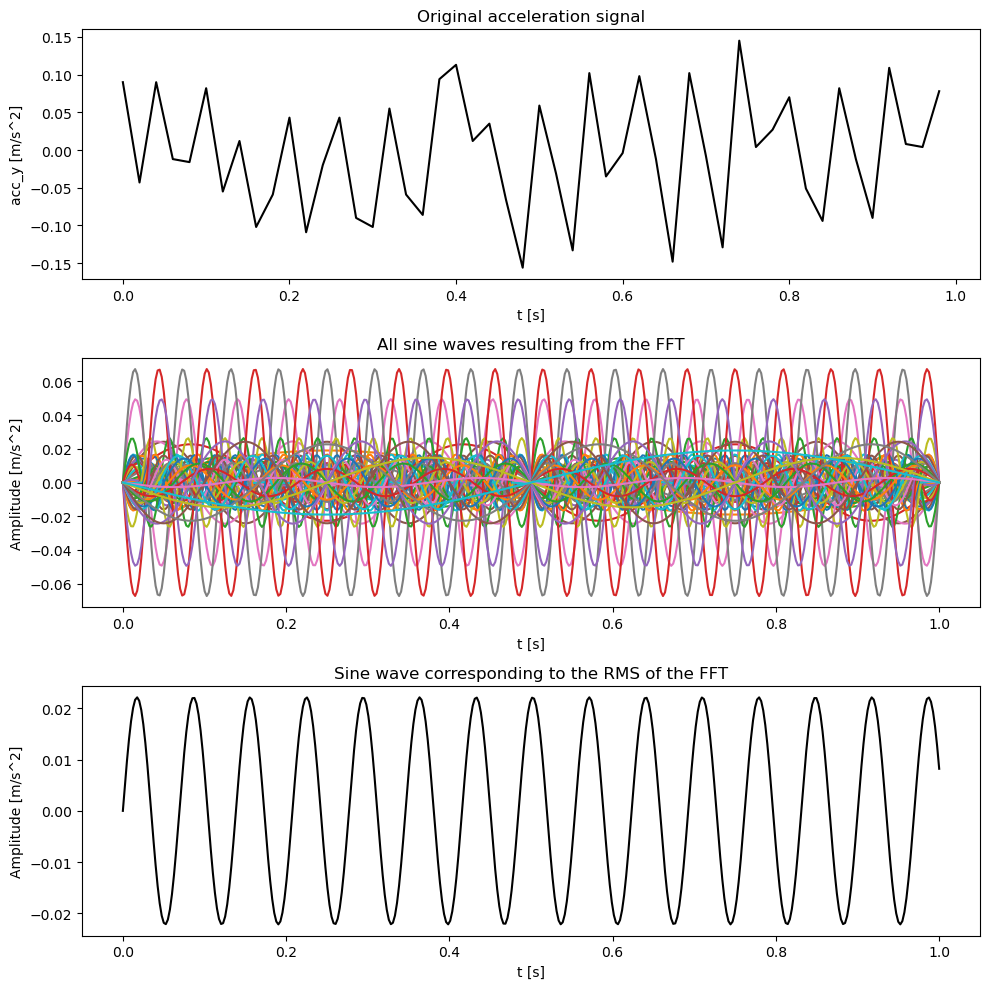

Number of windows:  3060


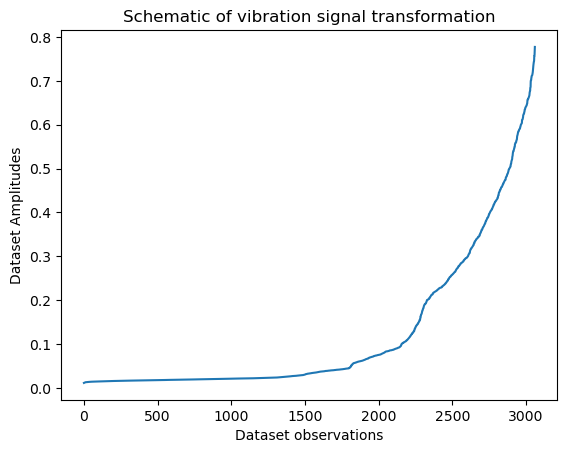

In [6]:
# first window with plot
res, _ = calculate_and_plot_fft(measurement_windows[0, :, 3], plot=True)

rms_values = []
print("Number of windows: ", np.size(measurement_windows, axis=0))
for j in range(np.size(measurement_windows, axis=0)):
    val, _ = calculate_and_plot_fft(measurement_windows[j, :, 3], plot=False)
    rms_values.append(val)

fig, (ax1) = plt.subplots(1, 1)
# The values in the presented plot are ordered by the size
rms_values.sort()
ax1.plot(rms_values)
ax1.set_title("Schematic of vibration signal transformation")
ax1.set_xlabel("Dataset observations")
ax1.set_ylabel("Dataset Amplitudes")
# ax1.set_xlim([0,500])
# ax1.set_ylim([0, 0.9])
plt.show()

In [7]:
# re-calculate all Fourier Data
fourier_data = np.empty(shape=[0, 6])
for j in range(np.size(measurement_windows, axis=0)):
    x_mag, x_freq = calculate_and_plot_fft(
        measurement_windows[j, :, 2], plot=False
    )
    y_mag, y_freq = calculate_and_plot_fft(
        measurement_windows[j, :, 3], plot=False
    )
    z_mag, z_freq = calculate_and_plot_fft(
        measurement_windows[j, :, 4], plot=False
    )
    fourier_data = np.append(
        fourier_data, [[x_mag, x_freq, y_mag, y_freq, z_mag, z_freq]], axis=0
    )

### Generate Final Data Set

To calculate the estimated failure time, three steps were performed in the dataset. The first step was to
establish vibration signal growth rates for the observations, doubling the dataset for the amount of
desired growth rates. Three growth rates gr of the signal were set: 0.01, 0.02 and 0.05.

In [8]:
def duplicate_with_values(values, n, data):
    growth_col = np.array([])
    training_data = np.empty(shape=[0, np.size(data, axis=1)])
    for i in range(len(values)):
        col = np.empty(n)
        col.fill(values[i])
        growth_col = np.append(growth_col, col)
        training_data = np.concatenate((training_data, data))

    new_size = n * len(values)
    training_data = np.array(
        [np.append(training_data[i], growth_col[i]) for i in range(new_size)]
    )
    return training_data

In [9]:
growth_rates = [0.01, 0.02, 0.05]

num_windows = np.size(measurement_windows, axis=0)
training_data = duplicate_with_values(growth_rates, num_windows, fourier_data)

print(np.size(fourier_data, axis=0))
print(np.size(training_data, axis=0))

3060
9180


The second step was to calculate the time, in windows of measurement, so that each amplitude reached the threshold value
according to the growth rate established for each amplitude of the axes. This calculation is given by

In [10]:
def calculate_failure_time(amplitude, threshold_value, growth_rate):
    failure_time = (threshold_value - amplitude) / (amplitude * growth_rate)
    return failure_time

Finally, the third step was to
calculate the average between the failure times, generating the expected equipment failure time. Thus,
given the input x = {x1, x2, ..., xn} and the signal growth rate gr, the expected output representing the
estimated failure time FTe is given by

In [11]:
def calculate_estimated_failure_time(
    failure_times,
):  # actually, this is a simple mean
    n = len(failure_times)
    return sum(failure_times) / n

In [12]:
threshold_values = [0.25, 0.7, 0.7]  # [x, y, z]
num_samples = np.size(training_data, axis=0)

eft = np.array([])
for i in range(num_samples):
    failure_time_x = calculate_failure_time(
        training_data[i, 0], threshold_values[0], training_data[i, 6]
    )
    failure_time_y = calculate_failure_time(
        training_data[i, 2], threshold_values[1], training_data[i, 6]
    )
    failure_time_z = calculate_failure_time(
        training_data[i, 4], threshold_values[2], training_data[i, 6]
    )
    failure_times = [failure_time_x, failure_time_y, failure_time_z]
    eft = np.append(
        eft, 4 * calculate_estimated_failure_time(failure_times)
    )  # factor 4 needed for some reason (probably R to python conversion)


training_data = np.array(
    [np.append(training_data[i], eft[i]) for i in range(num_samples)]
)

In [24]:
# This function summarizes the whole preprocessing (after fourier transform)


def gen_training_data(growths, thresholds, data):
    num_windows = np.size(data, axis=0)
    training_data = duplicate_with_values(growths, num_windows, data)
    num_samples = np.size(training_data, axis=0)

    eft = np.array([])
    for i in range(num_samples):
        failure_times = []
        for j in range(len(threshold_values)):
            failure_times.append(
                calculate_failure_time(
                    training_data[i, j * 2],
                    thresholds[j],
                    training_data[i, -1],
                )
            )
        eft = np.append(
            eft, 4 * calculate_estimated_failure_time(failure_times)
        )

    processed_data = np.array(
        [np.append(training_data[i], eft[i]) for i in range(num_samples)]
    )
    return processed_data, eft

### Print Plot of failure times

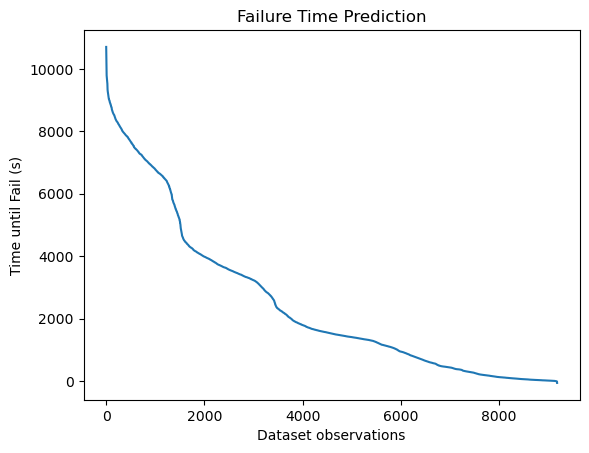

In [25]:
fig, (ax1) = plt.subplots(1, 1)
# failure times plotted over size in the paper
eft[::-1].sort()
ax1.plot(eft)
ax1.set_title("Failure Time Prediction")
ax1.set_xlabel("Dataset observations")
_ = ax1.set_ylabel("Time until Fail (s)")

### Dump Data to File

In [26]:
header = "x-Amplitude,x-Frequency,y-Amplitude,y-Frequency,z-Amplitude,z-Frequency,Growth-rate,Estimated-Failure-Time"
np.savetxt(
    "./data/processed_data.csv",
    training_data,
    delimiter=",",
    header=header,
    comments="",
)

### Generate Alternative Test Datasets

Two new datasets were generated with different amplitude values and vibration signal
growth rates in relation to the original training dataset, in order to attest to the generalizability of
the trained model. Both datasets for generalization served as input to the models and the RMSE
values of these new tests were calculated. Generalization dataset (a) was generated with the same
vibration amplitude values as the models’ original training dataset, but with different growth rate
values of 0.015, 0.03, and 0.04, totaling 9180 observations.

In [27]:
growth_rates = [0.015, 0.03, 0.04]
threshold_values = [0.25, 0.7, 0.7]

test_data, eft = gen_training_data(
    growth_rates, threshold_values, fourier_data
)

print("Number of samples: ", np.size(training_data, axis=0))

Number of samples:  9180


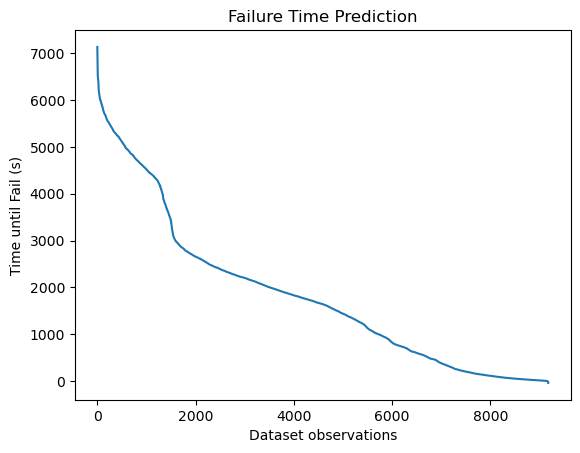

In [28]:
fig, (ax1) = plt.subplots(1, 1)
eft[::-1].sort()
ax1.plot(eft)
ax1.set_title("Failure Time Prediction")
ax1.set_xlabel("Dataset observations")
_ = ax1.set_ylabel("Time until Fail (s)")

In [29]:
header = "x-Amplitude,x-Frequency,y-Amplitude,y-Frequency,z-Amplitude,z-Frequency,Growth-rate,Estimated-Failure-Time"
np.savetxt(
    "./data/test_data_a.csv",
    test_data,
    delimiter=",",
    header=header,
    comments="",
)

Generalization dataset (b) was produced
with the average amplitude values for each cooler motor rotation speed in the three weight settings of
its blades, doubled by the vibration signal growth rates of 0.015, 0.03 and 0.04 totaling 153 observations.

In [35]:
def get_means(data, segment_length):
    assert np.size(data, axis=0) % segment_length == 0
    avg_data = []
    start_id = 0
    while start_id < np.size(data, axis=0):
        avgs = []
        for i in range(np.size(data, axis=1)):
            avgs.append(
                np.mean(data[start_id : (start_id + segment_length), i])
            )
        avg_data.append(avgs)
        start_id = start_id + segment_length
    return avg_data


segment = 60  # 3000 records divided by 50 (number of records per window)
avg_data = get_means(fourier_data, segment)
avg_data = np.array(avg_data)

[0.2814741642001266, 0.2887905815638731, 0.02283552959193749, 0.2887905815638731, 0.03725170870629437, 0.2887905815638731]
[0.28154453525401374, 0.2887905815638731, 0.021458103229319226, 0.2887905815638731, 0.037058149924807306, 0.2887905815638731]
[0.28148896238881416, 0.2887905815638731, 0.015677323607696952, 0.2887905815638731, 0.03630425627190572, 0.2887905815638731]
[0.2815265476139542, 0.2887905815638731, 0.0187863145817433, 0.2887905815638731, 0.03689188966252403, 0.2887905815638731]
[0.2814494871954023, 0.2887905815638731, 0.02582886535120896, 0.2887905815638731, 0.04012375108211606, 0.2887905815638731]
[0.28142166992559664, 0.2887905815638731, 0.03931721507896683, 0.2887905815638731, 0.04535856039049711, 0.2887905815638731]
[0.2812530778634253, 0.2887905815638731, 0.058736658908572825, 0.2887905815638731, 0.05372806748396217, 0.2887905815638731]
[0.2832376177666243, 0.2887905815638731, 0.08658929027765264, 0.2887905815638731, 0.06042946326296093, 0.2887905815638731]
[0.2832998

In [31]:
growth_rates = [0.015, 0.03, 0.04]
threshold_values = [0.25, 0.7, 0.7]

test_data, eft = gen_training_data(growth_rates, threshold_values, avg_data)
print("Number of samples: ", np.size(test_data, axis=0))

Number of samples:  153


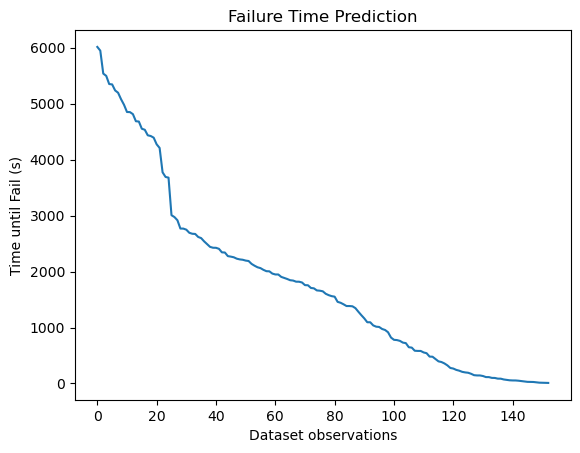

In [32]:
fig, (ax1) = plt.subplots(1, 1)
eft[::-1].sort()
ax1.plot(eft)
ax1.set_title("Failure Time Prediction")
ax1.set_xlabel("Dataset observations")
_ = ax1.set_ylabel("Time until Fail (s)")

In [33]:
header = "x-Amplitude,x-Frequency,y-Amplitude,y-Frequency,z-Amplitude,z-Frequency,Growth-rate,Estimated-Failure-Time"
np.savetxt(
    "./data/test_data_b.csv",
    test_data,
    delimiter=",",
    header=header,
    comments="",
)